# History

- 평가 지표 : MAE, RMSE, SMAPE

참고 링크:
- [모델 뼈대 (Kaggle, Chris)](https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold#Train-GRU)
- [CNN-LSTM, GRU-CNN](https://www.mdpi.com/2076-3417/13/7/4644)



#### Version 2
    - Close, Open, Volume 등 추가
    - scaler 코드 함수화


#### Future Work

- 수익률 값이 애초에 너무 작기에 Loss가 제대로 먹히지 않는 느낌이다. 해결책은 찾아보자.
- Feature를 추가해본다.
- 교차검증을 시도한다.
- Model hyperparameter를 조정해본다.
- (Update) 모델 구조 변경, CNN-LSTM 추가


# Library

In [1]:

# ----- Basic setup ----- #
import pandas as pd
import numpy as np
from os.path import join as opj
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import random, os
from IPython.display import clear_output
import calendar
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = None

# 교육자료
# np.set_printoptions(precision=6, suppress=True)

# pd.options.display.float_format = '{:.5f}'.format
# pd.reset_option('display.float_format')

# import random
# import os
# from tqdm.notebook import tqdm

# ----- scikit learn ----- #
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # GroupKFold
# r2_score를 제외한 나머지 평가지표들은 클수록 안 좋고, 1보다 큰 값도 왕왕 등장합니다.
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
# -1 ~ 1 사이, 0~1사이로 값의 단위를 고정시켜줍니다. : 정규화

# R2 score : 1 - sum((y_true - y_pred) ** 2) / sum((y_true - y_true.mean())**2)
# 1에 가까울 수록 좋은 모델, 0에 가까울 수록 나쁨, 음수가 나오면 잘못 평가 되었음을 의미합니다.

# ----- tensorflow & keras ----- #

from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator # https://github.com/keras-team/keras/blob/cdffff886626e5a05bc5d54b8a4634f1e5db06cf/keras/preprocessing/sequence.py#L56
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf


# ----- visualization ----- #
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot

# yahoo financial, unofficial way, rate limit
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()



!pip install ta
import ta

clear_output()

# Configuration

In [2]:
%%writefile config.yml

# 주석은 값에서 띄어쓰기를 꼭해줘야 한다. (yaml의 특성이 아닌 Namespace의 특성일 수도 있다.)
base:
  exp_name: exp_01
  task_name: asset # asset or portfolio
  model_name: LSTM # GRU, CNN_LSTM, GRU_CNN, xgboost
  use_gpu: false
  index_name: ^BVSP # ^BVSP : 브라질,  ^TWII : 대만, ^BSESN : 인도
  seed: 813
  base_dir: /content/ # /drive/MyDrive/~~~
  output_dir: ./
  #log_file: train_log.log

data:
  lookback_window: 10 #  look back period 5 21 42
  lookahead_window: 1 # 62 # 5 3개월 후로 고정되어 있으므로... 62는 장 개장일 기준으로 3개월 후한 첫 번째 값의 간격. 즉 17.01.02-> 17.04.03 사이에 62개
  y_form: ratio # value #
  feature_list:
    - Open
    - High
    - Low
    - Close # 수익률 계산을 위해 혹은 종가로 사용하기 위해서라도 반드시 포함되어야 한다.
    - HLmean # H + L / 2
    - OCmean # O + C / 2
    - Volume
    - ATR
    - Parabolic SAR
    - MACD
    - SMA
    - EMA
    - RSI
    - day
    - month
    - dayofweek
    - weekofmonth


train:
  #dataset:
  start_date: 2017-01-01
  end_date: 2020-12-31
  use_derive_vairable: true

  #training setting:
  verbose: 2


valid:
  #dataset:
  start_date: 2021-01-01
  end_date: 2021-12-31
  use_derive_vairable: true

test:
  #dataset:
  start_date: 2022-01-01
  end_date: 2022-12-31

Overwriting config.yml


In [3]:
import yaml
# pyyaml docs : https://pyyaml.org/wiki/PyYAMLDocumentation
from types import SimpleNamespace
# Ref : https://github.com/ybabakhin/kaggle-feedback-effectiveness-1st-place-solution/blob/main/train.py
# Ref : https://github.com/ybabakhin/kaggle-feedback-effectiveness-1st-place-solution/blob/main/yaml/awesome-rose-ff.yaml

# 예시로 살펴볼 수 있는 하나의 yaml 파일 : https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.6/configs/cls/cls_mv3.yml

cfg = yaml.safe_load(open("/content/config.yml").read())
for k, v in cfg.items():
    if type(v) == dict:
        cfg[k] = SimpleNamespace(**v)
cfg = SimpleNamespace(**cfg)
# logger(cfg)
print(cfg)

# config_file = "config.yml"
# with open(config_file) as f:

#     cfg = yaml.load(f, Loader=yaml.FullLoader)

# print(cfg)

namespace(base=namespace(exp_name='exp_01', task_name='asset', model_name='GRU', use_gpu=False, index_name='^BSESN', seed=813, base_dir='/content/', output_dir='./'), data=namespace(lookback_window=10, lookahead_window=1, y_form='ratio', feature_list=['Open', 'High', 'Low', 'Close', 'HLmean', 'OCmean', 'Volume']), train=namespace(start_date=datetime.date(2017, 1, 1), end_date=datetime.date(2020, 12, 31), use_derive_vairable=True), valid=namespace(start_date=datetime.date(2021, 1, 1), end_date=datetime.date(2021, 12, 31), use_derive_vairable=True), test=namespace(start_date=datetime.date(2022, 1, 1), end_date=datetime.date(2022, 12, 31)))


# Utilities

In [4]:
import logging
from os.path import join as opj


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# cfg_base로 바꾸기
def get_logger(cfg_base):

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    handler1 = logging.StreamHandler()
    handler1.setFormatter(logging.Formatter("%(message)s")) # 시간을 넣어줘야겠어..
    handler2 = logging.FileHandler(filename=opj(cfg_base.output_dir, f"{cfg_base.task_name}_{cfg_base.model_name}_{cfg_base.exp_name}.log"))
    handler2.setFormatter(logging.Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger(cfg.base)



### STANDARIZE
def scaler(x_data,y_data, cfg_base, is_train=False):
    """
    만약 필요하다면 feature 이름과 mn, std를 매칭 시켜서 저장해야 할 수도 있겠다. 순서가 항상 동일하다는 것을 보장할 수 없으니.
    이전에 비해 cfg.data.feature_list 바뀌면 바꿔야 한다.

    현재는 y_data scaling하지 않는다.
    """
    if is_train:
        mn = np.mean(x_data, axis=(0,1))
        sd = np.std(x_data, axis=(0,1))

        with open(opj(cfg.base.output_dir, f"{cfg_base.task_name}_{cfg_base.model_name}_{cfg_base.exp_name}_mn.npy"), "wb") as f:
            np.save(f, mn)
        with open(opj(cfg.base.output_dir, f"{cfg_base.task_name}_{cfg_base.model_name}_{cfg_base.exp_name}_sd.npy"), "wb") as f:
            np.save(f, sd)
    else:
        logger.info("is_train is False!!!!")
        with open(opj(cfg.base.output_dir, f"{cfg_base.task_name}_{cfg_base.model_name}_{cfg_base.exp_name}_mn.npy"), "rb") as f:
            mn = np.load(f)
        with open(opj(cfg.base.output_dir, f"{cfg_base.task_name}_{cfg_base.model_name}_{cfg_base.exp_name}_sd.npy"), "rb") as f:
            sd = np.load(f)

    x_data = (x_data - mn)/sd
    # y_data = (y_data - mn)/sd

    if is_train:
        logger.info(f"Average ratio =,{mn},and Average std =, {sd}")

    return x_data, y_data

# import calendar
# import numpy as np
# calendar.setfirstweekday(6)
# Ref : https://stackoverflow.com/questions/3806473/week-number-of-the-month
def get_week_of_month(year, month, day):
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0]
    return(week_of_month)


# Data Generation

In [5]:
# %%capture
# !pip install ta
# import ta


# from talib import RSI, BBANDS, MACD

# macd, macdsignal, macdhist = MACD(df_1.Close, fastperiod=12, slowperiod=26, signalperiod=9)
# up, mid, low = BBANDS(df_1.Close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)
# rsi = RSI(df_1.Close, timeperiod=14)


# H, L, C, V = train['high'], train['low'], train['close'], train['volume']
# merge_outer['ATR'] = ta.volatility.average_true_range(high=H, low=L, close=C, fillna=True)


# merge_outer['Parabolic SAR'] = ta.trend.psar_down(high=H, low=L, close=C, fillna=True)


# merge_outer['MACD'] = ta.trend.macd(close=C, fillna=True)


# merge_outer['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)


# merge_outer['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)


# merge_outer['RSI'] = ta.momentum.rsi(close=C, fillna=True)
# train['RSI'] = ta.momentum.rsi(close=C, fillna=True)

# train['Parabolic SAR'] = ta.trend.psar_down(
#     high=H, low=L, close=C, fillna=True)
# test['Parabolic SAR'] = ta.trend.psar_down(
#     high=H_test, low=L_test, close=C_test, fillna=True)


# train['day'] = train.index.day
# train['month'] = train.index.month
# # train['year'] = train.index.year
# train['dayofweek'] = train.index.dayofweek


# C = train['Close']
# a = ta.trend.sma_indicator(close=C, fillna=True)


# # 지우누나
# import ta
# close = raw_train['close']
# rsi = ta.momentum.rsi(close)
# macd = ta.trend.macd(close)
# macdsignal = ta.trend.macd_signal(close)
# bol_h = ta.volatility.bollinger_hband(close)
# bol_avg = ta.volatility.bollinger_mavg(close)
# bol_l = ta.volatility.bollinger_lband(close)

CPI : https://www.investing.com/economic-calendar/brazilian-cpi-1165

fred : https://fred.stlouisfed.org/searchresults?st=cpi+brazil


In [6]:
def make_features(df_):
    """
        특징을 추가해주는 함수. -> 거시경제 등 API로 받아올 수 있다면 이 곳에 추가!
    """
    df = df_.copy()
    df['OCmean'] = (df['Open']+df['Close']).div(2)
    df['HLmean'] = (df['High']+df['Low']).div(2)


    H, L, C, V = df['High'], df['Low'], df['Close'], df['Volume']
    df['ATR'] = ta.volatility.average_true_range(high=H, low=L, close=C, fillna=True)
    df['Parabolic SAR'] = ta.trend.psar_down(high=H, low=L, close=C, fillna=True)
    df['MACD'] = ta.trend.macd(close=C, fillna=True)
    df['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
    df['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
    df['RSI'] = ta.momentum.rsi(close=C, fillna=True)


    df['day'] = df.Date.dt.day
    df['month'] = df.Date.dt.month
    df['week'] = df.Date.dt.week
    df['year'] = df.Date.dt.year
    df['dayofweek'] = df.Date.dt.dayofweek
    # 고려사항 : 예를 들어, 우리나라 증권시장의 선물·옵션 동시 만기일은 매년 3, 6, 9, 12월 두 번째 목요일이에요.
    df['weekofmonth'] = df.apply(lambda row: get_week_of_month(row['year'], row['month'], row['day']), axis=1)
    
    return df

def make_data(df, cfg_data, return_to_df=False):
    """
        cfg data feature_list에 있는 feature을 활용해 시계열 데이터를 만드는 함수
    """
    df = make_features(df)
    df = df[cfg_data.feature_list].copy()
    # change into uncommented code (delete "+1" in -1 axis of df.iloc). caused by  IndexError: index 1230 is out of bounds for axis 0 with size 1230
    # total_sample_num = df.iloc[cfg_data.lookback_window-1:-cfg_data.lookahead_window+1].shape[0]
    total_sample_num = df.iloc[cfg_data.lookback_window-1:-cfg_data.lookahead_window].shape[0]


    # 수익 계산 위해 사용
    fea_num = df.columns.get_loc("Close")

    # 특징 하나일 떄는 아래와 같이 사용
    # x_data = np.zeros((total_sample_num, cfg_data.lookback_window, 1))
    x_data = np.zeros((total_sample_num, cfg_data.lookback_window, df.shape[1]))
    y_data = np.zeros((total_sample_num, 1))

    end_date = cfg_data.lookback_window-1

    for idx in tqdm(range(total_sample_num)):

        # 특징 하나일 떄는 아래와 같이 사용
        # x_data[idx,] = df.iloc[idx:idx+cfg_data.lookback_window, fea_num].values
        x_data[idx,] = df.iloc[idx:idx+cfg_data.lookback_window, :].values

        # 반복 효율을 위해 a로 변환 가능 [a는 for문 밖으로]
        # a = end_date+cfg_data.lookahead_window
        # y_data[idx,] = df.iloc[idx+a, fea_num]/df.iloc[idx+end_date, fea_num]
        # y_data[idx,] = df.iloc[idx+end_date+cfg_data.lookahead_window, fea_num]/df.iloc[idx+end_date, fea_num]-1
        y_data[idx,] = df.iloc[idx+end_date+cfg_data.lookahead_window, fea_num]/df.iloc[idx+end_date, fea_num]-1
    # pd.DataFrame(y_data).describe()

    if return_to_df:
        pass
        # FEATURES = [f'f{x}' for x in range(WIDTH-COPIES-4-1)]
        # TARGETS = [f'y{x}' for x in range(5)]
        # train_data = pd.DataFrame(x_data3,columns=FEATURES)
        # train_data[TARGETS] = y_data3
        # train_data['cfips'] = np.repeat(KEEP,COPIES)
        # print('Our GRU training data has shape:', train_data.shape )
        # train_data.head()
    else:
        return x_data, y_data



# Model

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU  (docs)
# Ref : https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold?scriptVersionId=133950942&cellId=35
def build_rnn_model(cfg):

    inp = tf.keras.Input(shape=(cfg.data.lookback_window,len(cfg.data.feature_list))) # INPUT SHAPE IS

    assert cfg.base.model_name in ['GRU', 'LSTM'], "check model_name"

    RNN = getattr(layers, cfg.base.model_name)
    x = RNN(units=64, return_sequences=False)(inp)
    # x = RNN(units=64, return_sequences=True)(inp)
    # x = RNN(units=32, return_sequences=True)(x)
    # x = RNN(units=8, return_sequences=False)(x)
    x = layers.Dense(1,activation='linear')(x) # OUTPUT SHAPE IS 5
    model = tf.keras.Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)

    return model

# Metric

In [8]:
# np.sqrt(sum((y_true - y_pred)**2)  / len(y_pred))
def rmse(y_true, y_pred):
    # sklearn.metrics 패키지에는 별도의 RMSE 평가지표는 없습니다
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Ref : https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold?scriptVersionId=133950942&cellId=40
def smape(y_true, y_pred):

    # CONVERT TO NUMPY
    y_true = np.array(y_true.flatten())
    y_pred = np.array(y_pred.flatten())

    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1

    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Run

학습까지만 진행하는 Run 부분

In [9]:
################################# LSTM #################################
# cfg.base.model_name = "LSTM"

################################# GRU (similar with LSTM) #################################

### 데이터 받아오기
train = pdr.get_data_yahoo(cfg.base.index_name, cfg.train.start_date, cfg.train.end_date).reset_index()
valid = pdr.get_data_yahoo(cfg.base.index_name, cfg.valid.start_date, cfg.valid.end_date).reset_index()
# test = pdr.get_data_yahoo(cfg.base.index_name, cfg.test.start_date, cfg.test.end_date).reset_index()

logger.info(f"train data start date : {train.Date.min()} end date : {train.Date.max()}")

### EDA

# train.query("Volume<10") Volume이 0인 경우 확인 필요
# label은 Scaling 안하는 것인가? Close


# FIRST DAY, LAST DAY
# train.first_day_of_month.min(), train.first_day_of_month.max()

### 학습 데이터 생성
x_data, y_data = make_data(train, cfg.data)
logger.info(f"!!Train data infoi!! \n  x_data.shape : {x_data.shape} \t y_data.shape : {y_data.shape}")


### STANDARIZE
x_data,y_data = scaler(x_data,y_data, cfg.base, is_train=True)

X_train, X_valid, y_train, y_valid = train_test_split(x_data, y_data, shuffle=True,random_state=cfg.base.seed, test_size=0.2)

### 모델
model = build_rnn_model(cfg)
logger.info(model.summary())

### 학습
h = model.fit(X_train,y_train,
                validation_data = (X_valid,y_valid),
                # sample_weight = np.tile(w,GRP),
                batch_size=4, epochs=10, verbose=2)

### 모델 저장
model.save_weights(f"{cfg.base.task_name}_{cfg.base.model_name}_{cfg.base.exp_name}.h5")
# model.load_weights(INFER_FROM_PATH + f'GRU_f{fold}_v{VER}.h5')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00
INFO:__main__:train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00


  0%|          | 0/973 [00:00<?, ?it/s]

!!Train data infoi!! 
  x_data.shape : (973, 10, 7) 	 y_data.shape : (973, 1)
INFO:__main__:!!Train data infoi!! 
  x_data.shape : (973, 10, 7) 	 y_data.shape : (973, 1)
Average ratio =,[ 35652.81820802  35821.5013969   35400.179605    35604.80359712
  35610.84050095  35628.81090257 342474.00822199],and Average std =, [   3953.83965302    3948.22616761    3934.97285453    3946.16570396
    3937.9155479     3946.37474191 2381109.3630446 ]
INFO:__main__:Average ratio =,[ 35652.81820802  35821.5013969   35400.179605    35604.80359712
  35610.84050095  35628.81090257 342474.00822199],and Average std =, [   3953.83965302    3948.22616761    3934.97285453    3946.16570396
    3937.9155479     3946.37474191 2381109.3630446 ]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 7)]           0         
                                                                 
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________


None
INFO:__main__:None


Epoch 1/10
195/195 - 7s - loss: 0.0017 - val_loss: 4.9817e-04 - 7s/epoch - 37ms/step
Epoch 2/10
195/195 - 1s - loss: 8.8230e-04 - val_loss: 0.0013 - 1s/epoch - 6ms/step
Epoch 3/10
195/195 - 1s - loss: 6.3492e-04 - val_loss: 4.2621e-04 - 1s/epoch - 6ms/step
Epoch 4/10
195/195 - 2s - loss: 0.0012 - val_loss: 8.8367e-04 - 2s/epoch - 8ms/step
Epoch 5/10
195/195 - 1s - loss: 4.9588e-04 - val_loss: 6.4433e-04 - 1s/epoch - 7ms/step
Epoch 6/10
195/195 - 2s - loss: 5.2354e-04 - val_loss: 3.1008e-04 - 2s/epoch - 8ms/step
Epoch 7/10
195/195 - 2s - loss: 3.9224e-04 - val_loss: 2.4012e-04 - 2s/epoch - 8ms/step
Epoch 8/10
195/195 - 1s - loss: 7.5182e-04 - val_loss: 3.1442e-04 - 1s/epoch - 7ms/step
Epoch 9/10
195/195 - 2s - loss: 3.7965e-04 - val_loss: 1.5989e-04 - 2s/epoch - 8ms/step
Epoch 10/10
195/195 - 1s - loss: 2.6839e-04 - val_loss: 1.7107e-04 - 1s/epoch - 7ms/step


In [10]:
# # scikit learn과 호환가능하도록 누군가가 커스터마이징해서 올려놓은 모델 = wrapper model, wrapper module
# from xgboost import XGBRegressor
# from xgboost import plot_importance

# xgbr = XGBRegressor()
# xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds= 110, verbose=False)
# ypred = xgbr.predict(X_test)
# score = xgbr.score(X_train, y_train)
# mse = mean_squared_error(y_test, ypred)

# print("Training score: ", score)
# print("MSE: %.2f" % mse)
# print("RMSE: %.2f" % (mse**(1/2.0)))

# import xgboost
# from xgboost import plot_importance, plot_tree
# from xgboost import XGBClassifier
# xgb = xgboost.XGBRegressor()
# xgb.fit(X_train, y_train)

# plot_importance(xgb, height=0.9)

# predictions = xgb.predict(X_val)

# Validation

In [11]:

#### 검증
x_data, y_data = make_data(valid, cfg.data)
logger.info(f"!!Valid data infoi!! \n  x_data.shape : {x_data.shape} \t y_data.shape : {y_data.shape}")
# 학습 때 활용했던 mn, sd 그대로 사용
### STANDARIZE
x_data,y_data = scaler(x_data,y_data, cfg.base,is_train=False)

preds = np.zeros(y_data.shape)

model = build_rnn_model(cfg)
model.load_weights(f"{cfg.base.task_name}_{cfg.base.model_name}_{cfg.base.exp_name}.h5")

preds = model.predict(x_data, verbose=2) # / FOLDS

  0%|          | 0/236 [00:00<?, ?it/s]

!!Valid data infoi!! 
  x_data.shape : (236, 10, 7) 	 y_data.shape : (236, 1)
INFO:__main__:!!Valid data infoi!! 
  x_data.shape : (236, 10, 7) 	 y_data.shape : (236, 1)
is_train is False!!!!
INFO:__main__:is_train is False!!!!


8/8 - 0s - 304ms/epoch - 38ms/step


In [12]:
logger.info(f"cfg.base.model_name : {cfg.base.model_name}")
logger.info(f"Metric Result : MAE : {mean_absolute_error(y_data, preds)} \t RMSE : {rmse(y_data, preds)} \t SMAPE : {smape(y_data, preds)}")

cfg.base.model_name : GRU
INFO:__main__:cfg.base.model_name : GRU
Metric Result : MAE : 0.014634684250342596 	 RMSE : 0.018114564357162934 	 SMAPE : 150.32220644079504
INFO:__main__:Metric Result : MAE : 0.014634684250342596 	 RMSE : 0.018114564357162934 	 SMAPE : 150.32220644079504


# Visualization

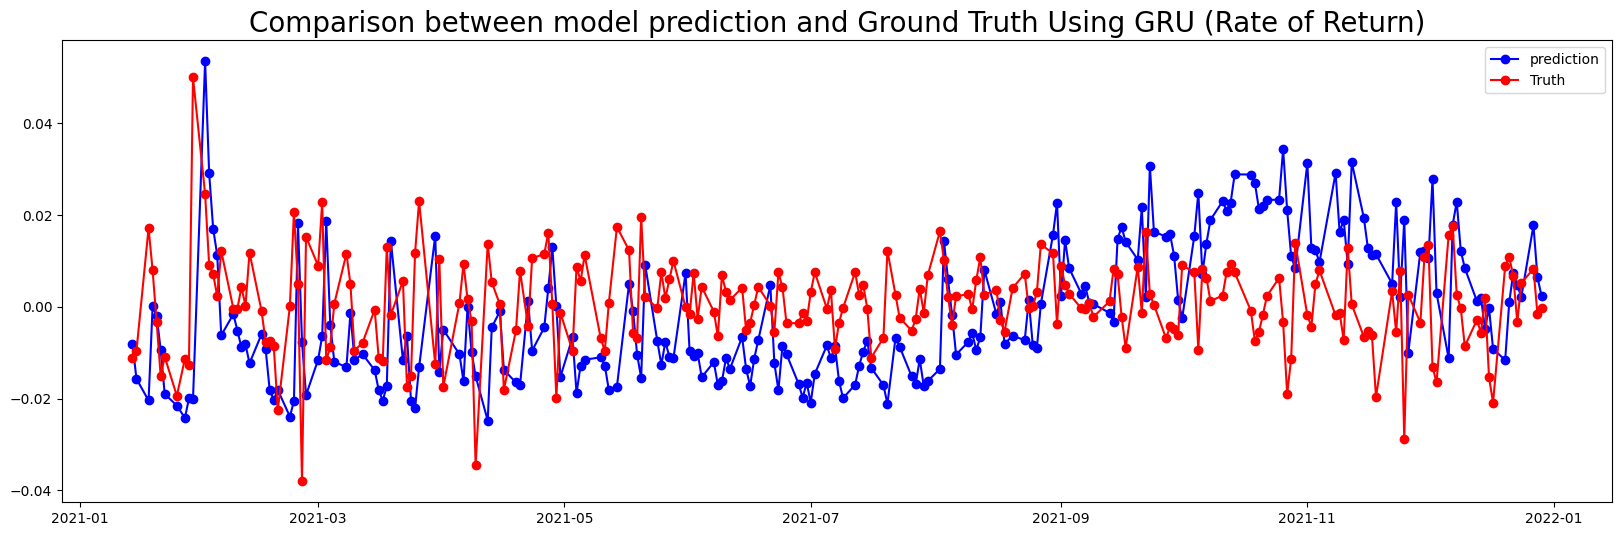

In [13]:
valid_date = valid.iloc[cfg.data.lookback_window-1:-cfg.data.lookahead_window].Date
visual_y_data = y_data.reshape(-1,)
visual_preds = preds.reshape(-1,)

plt.figure(figsize=(20,6))
plt.plot(valid_date, visual_preds, '-ob', label='prediction')
plt.plot(valid_date, visual_y_data, '-or', label='Truth')
plt.title(f'Comparison between model prediction and Ground Truth Using {cfg.base.model_name} (Rate of Return)',size=20)
plt.legend()
plt.show()

In [ ]:
# Loss History Check
plt.figure(figsize=(20,6))
plt.plot(h.history['loss'], 'b', label='Train Loss')
plt.plot(h.history['val_loss'], 'r', label='Valid Loss')
plt.title(f'Loss History per epoch',size=20)
plt.legend()
plt.show()